In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
# importing sys
import sys
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/Users/glover.co/Documents/laszlo/NetDesign')
import network_design as nd
import time
from matplotlib.colors import to_rgba
import matplotlib.animation as animation

### Question: Can networks formed from components be correctly made if there exists one label for each node?

In [7]:
g = nx.fast_gnp_random_graph(100, 0.05, directed=False)
# g = nx.k_core(g,1)
g = nx.subgraph(g,sorted(list(nx.connected_components(g)),key=len,reverse=True)[0])
X = np.eye(g.number_of_nodes())
O = nd.extract_O(g,X)
new_X = np.vstack((X,X))
random_network = nd.NetAssembly(new_X,O,new_X.sum(axis=0,dtype=int),system_energy=1)
og_g = nd.NetAssembly(new_X,O,new_X.sum(axis=0,dtype=int),system_energy=1)
og_g.g = g

IndexError: index 99 is out of bounds for axis 0 with size 98

In [14]:
og_g.draw(with_networkx=False,output='og_g.png')

<Figure size 500x500 with 0 Axes>

In [15]:
random_network.run(10000,link_strength=.01)

KeyboardInterrupt: 

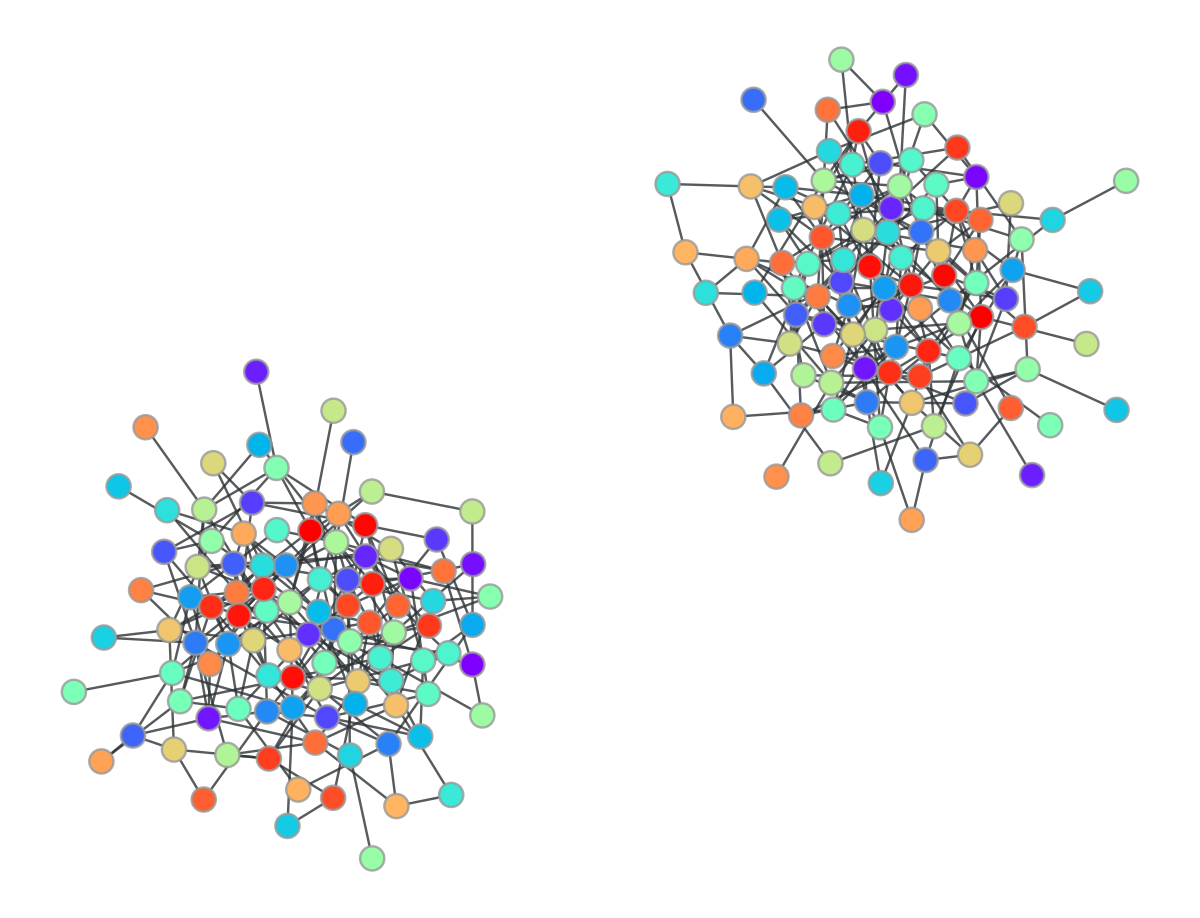

<Figure size 500x500 with 0 Axes>

In [37]:
random_network.draw(with_networkx=False)

In [38]:
nx.is_isomorphic(random_network.g,nx.disjoint_union(g,g))

True

In [19]:
np.divide(random_network.A@random_network.X.sum(axis=1),random_network.X@random_network.O.sum(axis=1))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [20]:
random_network.A@random_network.X.sum(axis=1)

array([5., 4., 3., 3., 5., 5., 6., 5., 2., 4., 5., 4., 3., 3., 5., 5., 6.,
       5., 2., 4.])

In [91]:
g = nx.fast_gnp_random_graph(10,.4)


In [97]:
# Group nodes by degree where the key is the degree and the value is a list of nodes with that degree
degree_dict = {}
for node in g.nodes():
    degree = g.degree(node)
    if degree in degree_dict:
        degree_dict[degree].append(node)
    else:
        degree_dict[degree] = [node]


In [102]:
from itertools import combinations
# create a list of nodes which can share the same label
pairs_to_match = []
for k in degree_dict.keys():
    pairs_to_match += list(combinations(degree_dict[k],2))


In [2]:
def nonlinear_pa(N,m,alpha=1):
    """
    Generate a network with nonlinear preferential attachment

    Parameters:
        N (int) - number of nodes
        m (int) - number of links attached to incoming nodes
        alpha (float) - preferential attachment exponent

    Returns:
        nx.Graph
    """
    # Generate initial network
    g = nx.complete_graph(3)

    for i in range(3,N):
        # Get degree sequence
        deg_seq = np.array(g.degree())[:,1]
        # Get probabilities
        deg_alpha = np.power(deg_seq,alpha)
        prob = deg_alpha / np.sum(deg_alpha)
        
        # Add new node
        g.add_node(i)

        # Add link
        # Choose nodes
        links_to_add = np.random.choice(np.arange(i),p=prob,replace=False,size=m)
        # Add links
        for j in links_to_add:
            g.add_edge(i,j)

    A = nx.adjacency_matrix(g).toarray()
    node_order = np.arange(N)
    np.random.shuffle(node_order)
    A[np.arange(N),:] = A[node_order,:]
    A[:,np.arange(N)] = A[:,node_order]
    new_g = nx.Graph(A)
    for e in new_g.edges():
        del new_g[e[0]][e[1]]['weight']

    return new_g

random_network.g

In [6]:
component_check = np.zeros((11,10))
for j in range(10):
    for i, alpha in enumerate(np.linspace(0,2,11)):
        g = nonlinear_pa(100,3,alpha)
        X = np.eye(g.number_of_nodes())
        new_X = np.tile(X,reps=(2,1))
        O = nx.adjacency_matrix(g).toarray()
        obj = nd.NetAssembly(new_X,O,new_X.sum(axis=0,dtype=int))
        obj.run(10000,link_strength=.01)
        components = list(nx.connected_components(obj.g))
        for c in components:
            if nx.is_isomorphic(g,nx.subgraph(obj.g,c)):
                component_check[i,j] += 1


: 

In [4]:
component_check

array([0., 2., 0., 2., 0., 2., 0., 0., 0., 0., 0.])

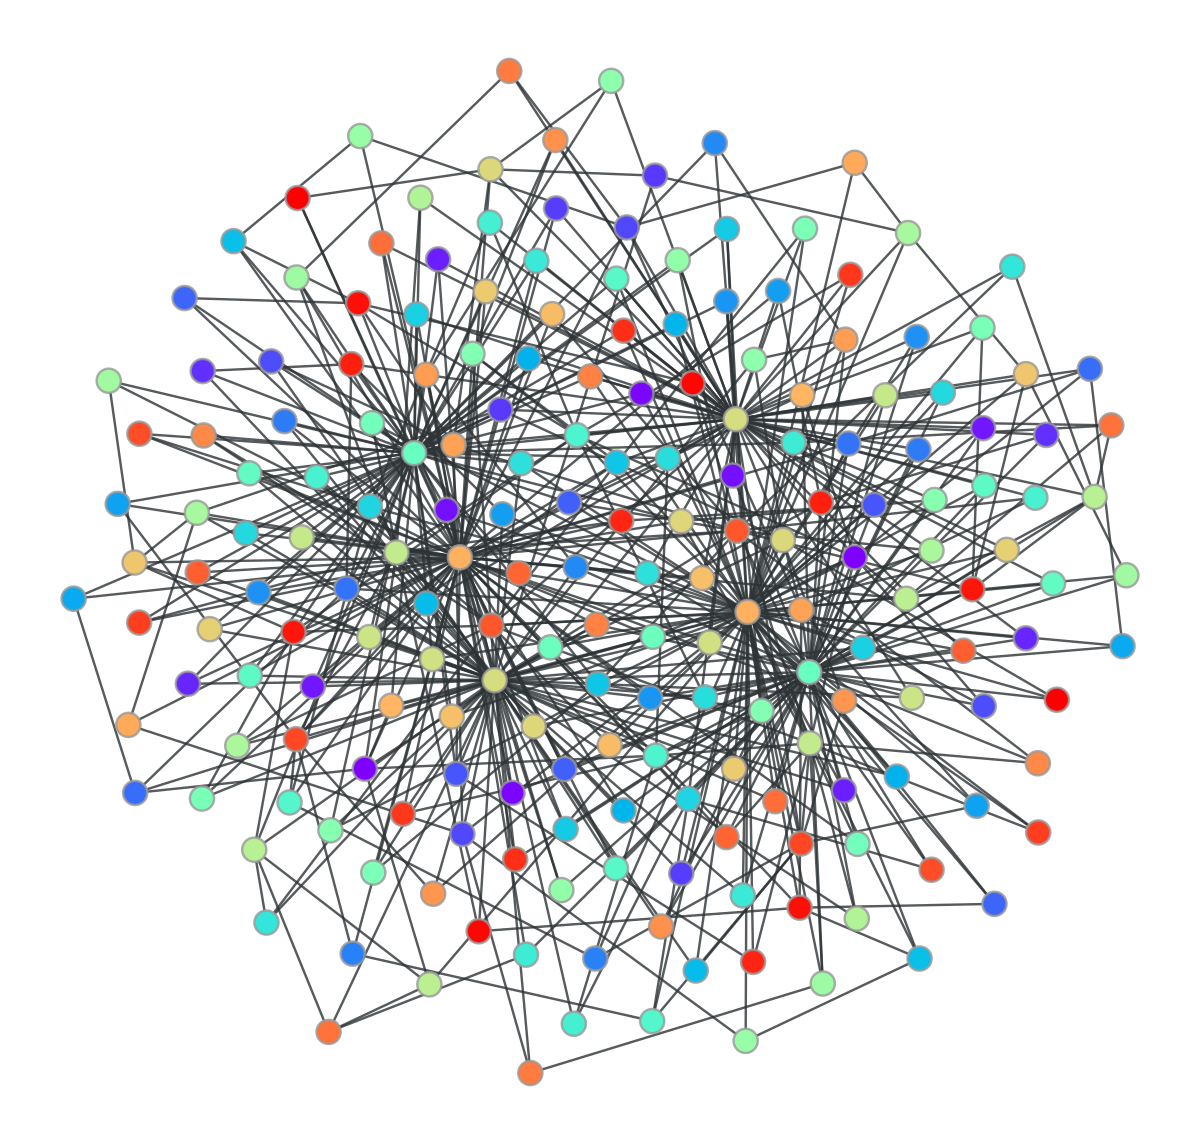

<Figure size 500x500 with 0 Axes>

In [5]:
obj.draw(with_networkx=False)